# Overview

The  [PASTIS](https://zenodo.org/record/5012942#.YzvzYnZBxPa) dataset is a dataset for evaluation of semantic and panoptic segmentation of agricultural parcels from Satellite Image Time Series.

Authors’ description can be found [here](https://drive.google.com/file/d/1Q4rXPTBqcr7NgB3RK-bv_wJWzaT7wpFL/view?usp=sharing). 
 
The PASTIS dataset consists of `4` different Sentinel-2 tiles in different regions of the French metropolitan territory. Each of these tiles span `100×100km` and is subdivided in square patches of size `1,28×1,28km`. The total amount of `128×128` square patches is `2433` with `10` spectral bands and at `10m` per pixel resolution.

For each patch, we stack all available acquisitions between September 2018 and November 2019, forming our four-dimensional multi-spectral SITS: `T × C × H × W`. Each patch pixel is annotated with a semantic label corresponding to either the parcels’ crop type or the background class. 

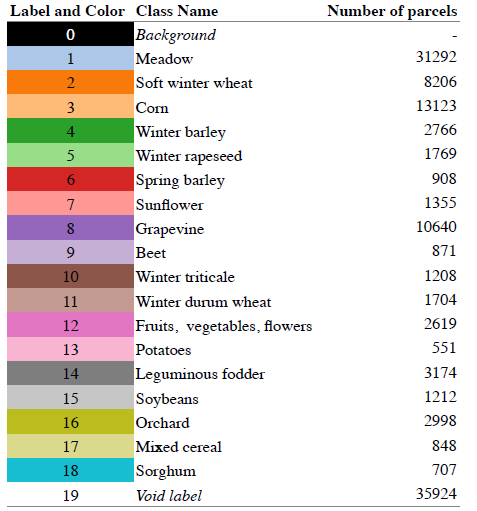

The *void label* is reserved for out-of-scope parcels, either because their crop type is not in our nomenclature or because their overlap with the selected square patch is too small.

Parcels whose surface is more than `50%` outside of the patch are annotated with the *void label*.

Parcels with an area of less than `800m2` or a perimeter of less than `10` meters are annotated with the *background*.

# Logger

In [1]:
import logging

# Remove all handlers associated with the root logger object.
for handler in logging.root.handlers[:]:
    logging.root.removeHandler(handler)
    
# Reconfigure logging again, this time with a file.
logging.basicConfig(level=logging.INFO, format='%(filename)s:%(lineno)s %(levelname)s:%(message)s')

# create logger
logger = logging.getLogger()

# Data Analysis

In [2]:
import random
import os
import json
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.colors import ListedColormap
import matplotlib
import cv2
import tensorflow as tf
from tensorflow import keras
import tensorflow_addons as tfa
from tensorflow.keras import mixed_precision
import keras.backend as K

# set the random seed:
RANDOM_SEED = 77
random.seed(RANDOM_SEED)

DATASET_DIR = '/kaggle/input/pastis/PASTIS/'

## Parse Metadata

In [3]:
class Singleton(type):
    _instances = {}

    def __call__(cls, *args, **kwargs):
        if cls not in cls._instances:
            cls._instances[cls] = super(Singleton, cls).__call__(*args, **kwargs)
        return cls._instances[cls]

class Metadata(metaclass=Singleton):
    def __init__(self):
        self.dataset_dir = DATASET_DIR
        self._metadata = self._load_metadata_dataframe()
        self._norm_metadata = self._load_norm_metadata()

    @property
    def metadata(self):
        return self._metadata

    @property
    def norm_metadata(self):
        return self._norm_metadata

    def _load_norm_metadata(self):
        return pd.read_json(os.path.join(self.dataset_dir, "NORM_S2_patch.json")).to_dict()

    def _load_metadata_dataframe(self):
        """
        Processing patch metadata and extracting the following features:
        Patch_path, Fold, Patch_id, N_parcel, Parcel_cover, Tile, i_date (date of time series object {i})
        :return: pandas dataframe with metadata of Sentinel-2 patches.
        """
        with open(os.path.join(self.dataset_dir, 'metadata.geojson')) as f:
            metadata = json.load(f)
            metadata = pd.json_normalize(metadata, record_path='features', max_level=1)

        # Processing dates
        dates = pd.DataFrame(metadata['properties.dates-S2'].values.tolist())
        for column in dates.columns:
            d = dates[column]
            dates[f'{column}_date'] = pd.to_datetime(d, format='%Y%m%d')
            dates.drop(columns=[column], inplace=True)

        metadata['Semantic_segmentation_path'] = metadata['properties.ID_PATCH'].apply(lambda x: f'{DATASET_DIR}ANNOTATIONS/TARGET_{x}.npy')
        metadata['Patch_path'] = metadata['properties.ID_PATCH'].apply(lambda x: f'{DATASET_DIR}DATA_S2/S2_{x}.npy')
        metadata.drop(
            columns=['id', 'type', 'properties.id', 'geometry.type', 'geometry.coordinates', 'properties.dates-S2'],
            inplace=True)
        metadata.rename(
            columns={'properties.Fold': 'Fold', 'properties.N_Parcel': 'N_parcel', 'properties.ID_PATCH': 'Patch_id',
                     'properties.Parcel_Cover': 'Parcel_cover', 'properties.TILE': 'Tile'}, inplace=True)

        patches_metadata = pd.concat([metadata, dates], ignore_index=False, axis=1)
        patches_metadata.set_index('Patch_path', inplace=True)

        return patches_metadata

patches_metadata = Metadata().metadata
patches_metadata

,Fold,Patch_id,N_parcel,Parcel_cover,Tile,Semantic_segmentation_path,0_date,1_date,2_date,3_date,...,51_date,52_date,53_date,54_date,55_date,56_date,57_date,58_date,59_date,60_date
Patch_path,,,,,,,,,,,,,,,,,,,,,
/kaggle/input/pastis/PASTIS/DATA_S2/S2_10000.npy,1,10000,119,0.808032,t30uxv,/kaggle/input/pastis/PASTIS/ANNOTATIONS/TARGET...,2018-09-24,2018-09-29,2018-10-04,2018-10-09,...,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
/kaggle/input/pastis/PASTIS/DATA_S2/S2_10001.npy,2,10001,111,0.501986,t30uxv,/kaggle/input/pastis/PASTIS/ANNOTATIONS/TARGET...,2018-09-24,2018-09-29,2018-10-04,2018-10-09,...,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
/kaggle/input/pastis/PASTIS/DATA_S2/S2_10002.npy,4,10002,131,0.638722,t30uxv,/kaggle/input/pastis/PASTIS/ANNOTATIONS/TARGET...,2018-09-24,2018-09-29,2018-10-04,2018-10-09,...,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
/kaggle/input/pastis/PASTIS/DATA_S2/S2_10003.npy,5,10003,75,0.866824,t30uxv,/kaggle/input/pastis/PASTIS/ANNOTATIONS/TARGET...,2018-09-24,2018-09-29,2018-10-04,2018-10-09,...,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
/kaggle/input/pastis/PASTIS/DATA_S2/S2_10004.npy,4,10004,46,0.204906,t30uxv,/kaggle/input/pastis/PASTIS/ANNOTATIONS/TARGET...,2018-09-24,2018-09-29,2018-10-04,2018-10-09,...,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
/kaggle/input/pastis/PASTIS/DATA_S2/S2_40558.npy,2,40558,33,0.783991,t32ulu,/kaggle/input/pastis/PASTIS/ANNOTATIONS/TARGET...,2018-09-17,2018-09-22,2018-09-27,2018-10-12,...,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
/kaggle/input/pastis/PASTIS/DATA_S2/S2_40559.npy,5,40559,24,0.129896,t32ulu,/kaggle/input/pastis/PASTIS/ANNOTATIONS/TARGET...,2018-09-17,2018-09-22,2018-09-27,2018-10-12,...,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
/kaggle/input/pastis/PASTIS/DATA_S2/S2_40560.npy,3,40560,7,0.255358,t32ulu,/kaggle/input/pastis/PASTIS/ANNOTATIONS/TARGET...,2018-09-17,2018-09-22,2018-09-27,2018-10-12,...,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT


In [4]:
patches_metadata.info(show_counts=True, verbose=True)

<class 'pandas.core.frame.DataFrame'>
Index: 2433 entries, /kaggle/input/pastis/PASTIS/DATA_S2/S2_10000.npy to /kaggle/input/pastis/PASTIS/DATA_S2/S2_40562.npy
Data columns (total 67 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   Fold                        2433 non-null   int64         
 1   Patch_id                    2433 non-null   int64         
 2   N_parcel                    2433 non-null   int64         
 3   Parcel_cover                2433 non-null   float64       
 4   Tile                        2433 non-null   object        
 5   Semantic_segmentation_path  2433 non-null   object        
 6   0_date                      2433 non-null   datetime64[ns]
 7   1_date                      2433 non-null   datetime64[ns]
 8   2_date                      2433 non-null   datetime64[ns]
 9   3_date                      2433 non-null   datetime64[ns]
 10  4_date                      2433 n

556 patches have only 38 satellite images

1254 patches have only 43 satellite images

623 patches have 61 satellite images

## Normalization

In [5]:
NUMBER_OF_SPECTRA = 10

def normalize_patch_spectra(patch):
    """Utility function to normalize the Sentinel-2 patch spectra.
       The patch must consist of 10 spectra and the shape n*n*10."""
    norms = Metadata().norm_metadata['Fold_1']
    return (patch - norms['mean']) / norms['std']

## UTILS

In [6]:
def upload_npy_image(path: str):
    return np.load(path)

def get_image_and_display_dataset_object_info(df_list):
    tensor = iter(df_list).get_next()
    path = tf.get_static_value(tensor).decode("utf-8")
    print(f'Path to the first dataset object: {path}')
    image = upload_npy_image(path)
    print(f'The shape of the array: {image.shape}')
    print(f'Array value range: [{np.amin(image)}, {np.amax(image)}]')
    return image

def reshape_patch_spectra(patch):
    """Utility function to reshape patch shape from k*128*128 to 128*128*k.
    """
    reshaped_image = patch.swapaxes(0,2).swapaxes(0,1)
    return reshaped_image


def get_rgb(time_series, t_show=-1):
    """Utility function to get a displayable rgb image 
       from a Sentinel-2 time series.
    """
    image = time_series[t_show, [2,1,0]]

    # Normalize image
    max_value = image.max(axis=(1,2))
    min_value = image.min(axis=(1,2))
    image_normalized = (image - min_value[:,None,None])/(max_value - min_value)[:,None,None]

    rgb_image = reshape_patch_spectra(image_normalized)
    return rgb_image

## DATA S2

In [7]:
patches_list = tf.data.Dataset.list_files(f'{DATASET_DIR}DATA_S2/*', shuffle=False)

print(f'There are {len(patches_list)} patches.')

tensor = iter(patches_list).get_next()
path = tf.get_static_value(tensor).decode("utf-8")
metadata = patches_metadata.loc[path]
print(path)

time_series = upload_npy_image(path)
print(time_series.shape)
print(f'spectra value range: [{np.amin(time_series)}, {np.amax(time_series)}]')

There are 2468 patches.
/kaggle/input/pastis/PASTIS/DATA_S2/S2_10000.npy
(43, 10, 128, 128)
spectra value range: [-1338, 13756]


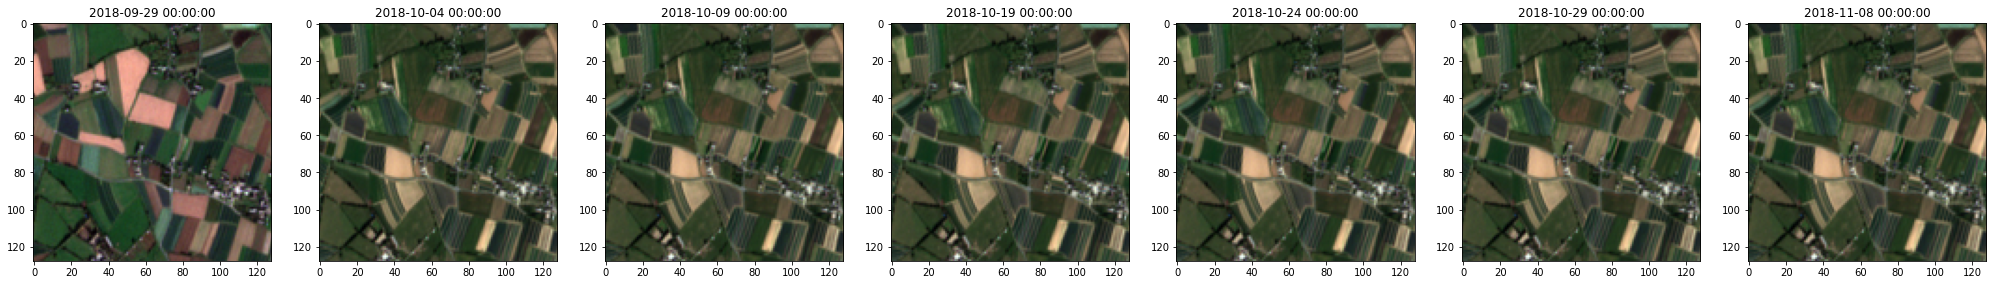

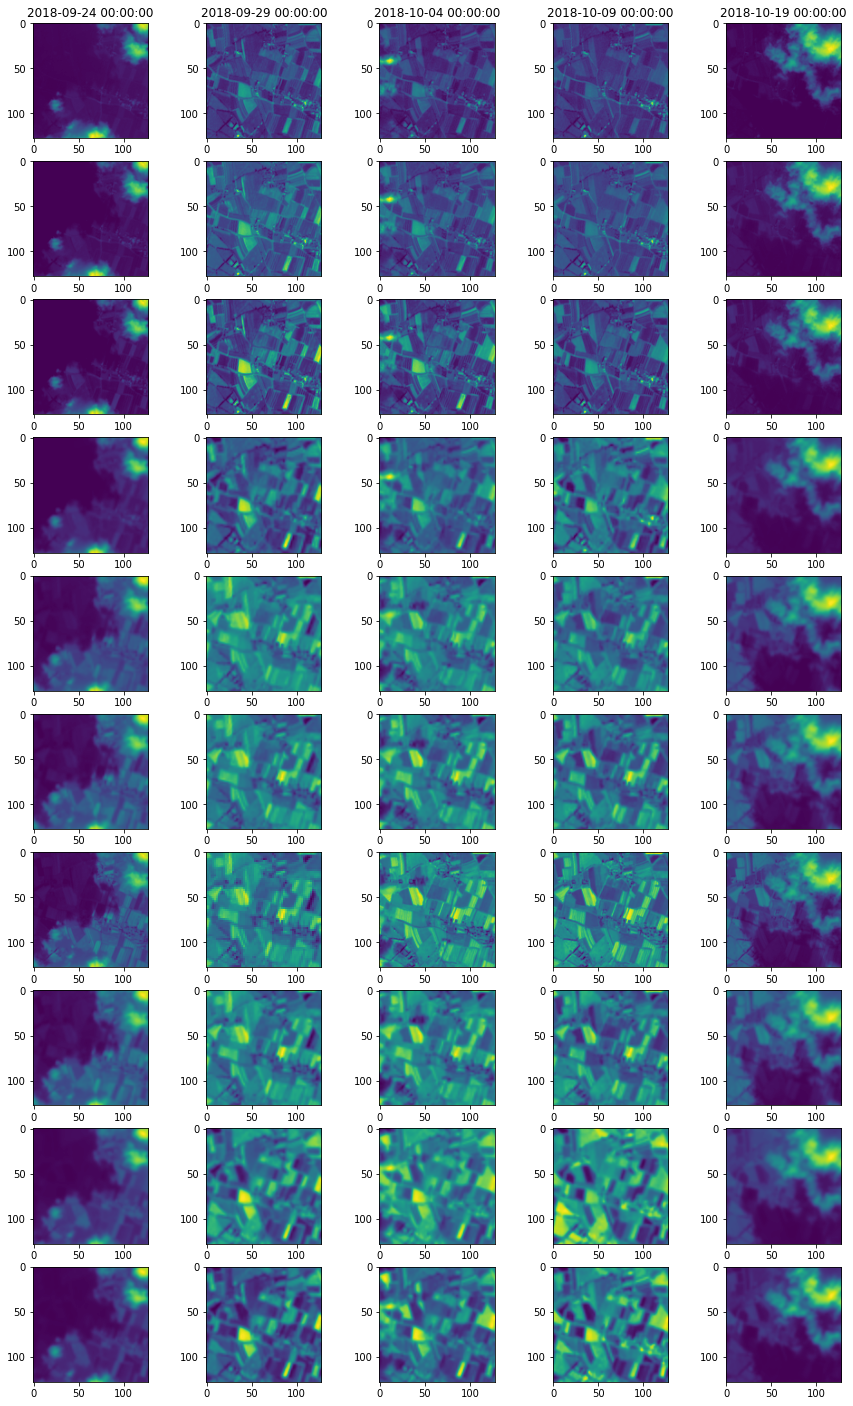

In [21]:
f,axs = plt.subplots(1, 7, figsize=(35,35 ))
axs[0].imshow(get_rgb(time_series, t_show=7))
axs[0].set_title(f"{metadata[f'{1}_date']}")
axs[1].imshow(get_rgb(time_series, t_show=1))
axs[1].set_title(f"{metadata[f'{2}_date']}")
axs[2].imshow(get_rgb(time_series, t_show=1))
axs[2].set_title(f"{metadata[f'{3}_date']}")
axs[3].imshow(get_rgb(time_series, t_show=1))
axs[3].set_title(f"{metadata[f'{4}_date']}")
axs[4].imshow(get_rgb(time_series, t_show=1))
axs[4].set_title(f"{metadata[f'{5}_date']}")
axs[5].imshow(get_rgb(time_series, t_show=1))
axs[5].set_title(f"{metadata[f'{6}_date']}")
axs[6].imshow(get_rgb(time_series, t_show=1))
axs[6].set_title(f"{metadata[f'{7}_date']}")

N = 5
f,axs = plt.subplots(10, N, figsize=(15, 25))
for day in range(N):
    for spectral in range(10):
        ax = axs[spectral % 10, day]
        ax.imshow(time_series[day][spectral])

columns = [f"{metadata[f'{i}_date']}" for i in range(N)]
for ax, col in zip(axs[0], columns):
    ax.set_title(col)

## Annotations

In [22]:
parcel_annotations = tf.data.Dataset.list_files(f'{DATASET_DIR}ANNOTATIONS/ParcelIDs_*', shuffle=False)
print(f'There are {len(parcel_annotations)} parcel ids annotations.')

parcel_annotation = get_image_and_display_dataset_object_info(parcel_annotations)

target_annotations = tf.data.Dataset.list_files(f'{DATASET_DIR}ANNOTATIONS/TARGET_*', shuffle=False)
print(f'There are {len(target_annotations)} target annotations.')

target_annotation = get_image_and_display_dataset_object_info(target_annotations)

semantic_target = target_annotation[0].astype(int)
print(f'Semantic target value range: [{np.amin(semantic_target)}, {np.amax(semantic_target)}]')

There are 2433 parcel ids annotations.
Path to the first dataset object: /kaggle/input/pastis/PASTIS/ANNOTATIONS/ParcelIDs_10000.npy
The shape of the array: (128, 128)
Array value range: [0, 15401718]
There are 2433 target annotations.
Path to the first dataset object: /kaggle/input/pastis/PASTIS/ANNOTATIONS/TARGET_10000.npy
The shape of the array: (3, 128, 128)
Array value range: [0, 119]
Semantic target value range: [0, 19]


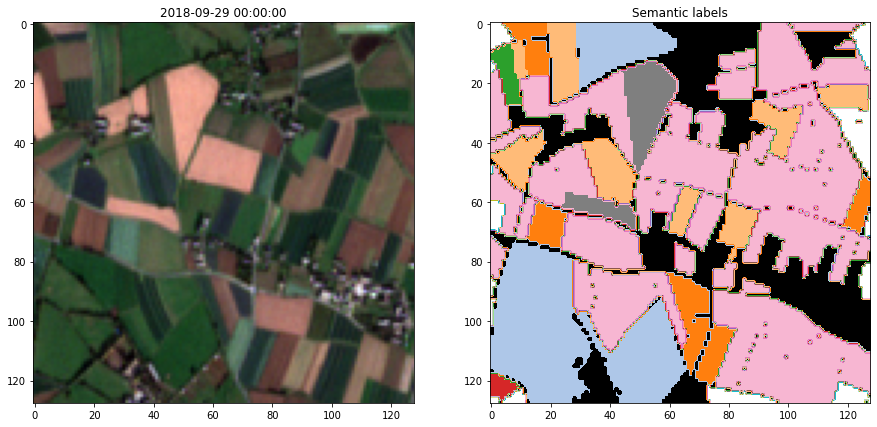

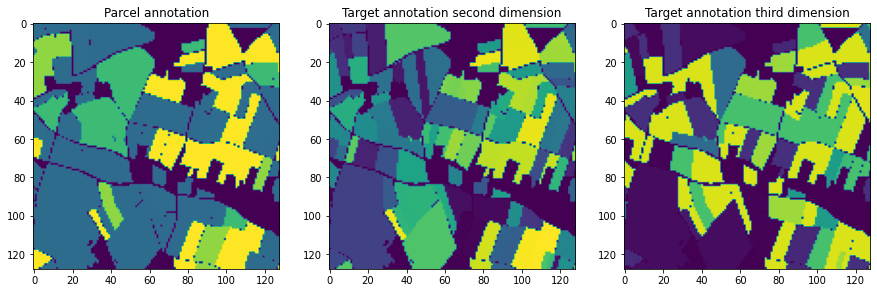

In [46]:
cm = matplotlib.cm.get_cmap('tab20')
def_colors = cm.colors
cus_colors = ['k'] + [def_colors[i] for i in range(1,20)]+['w']
semantic_cmap = ListedColormap(colors = cus_colors, name='agri',N=21)

f,axs = plt.subplots(1, 2, figsize=(15, 25))
# axs[0].imshow(get_rgb(time_series))
# axs[0].set_title('Satellite RGB images')
axs[0].imshow(get_rgb(time_series, t_show=7))
axs[0].set_title(f"{metadata[f'{1}_date']}")

axs[1].imshow(semantic_target, cmap=semantic_cmap, vmin=0, vmax=19)
axs[1].set_title('Semantic labels')

f,axs = plt.subplots(1, 3, figsize=(15, 25))
axs[0].imshow(parcel_annotation)
axs[0].set_title('Parcel annotation')
axs[1].imshow(target_annotation[1])
axs[1].set_title('Target annotation second dimension')
axs[2].imshow(target_annotation[2])
axs[2].set_title('Target annotation third dimension')

plt.show()

## Instance Annotations

In [33]:
all_instance_annotations = tf.data.Dataset.list_files(f'{DATASET_DIR}INSTANCE_ANNOTATIONS/*', shuffle=False)
print(f'There are {len(all_instance_annotations)} instance annotations.')

heatmap_annotations = tf.data.Dataset.list_files(f'{DATASET_DIR}INSTANCE_ANNOTATIONS/HEATMAP_*', shuffle=False)
print(f'There are {len(heatmap_annotations)} heatmap instance annotations.')
heatmap_annotation = get_image_and_display_dataset_object_info(heatmap_annotations)

zones_annotations = tf.data.Dataset.list_files(f'{DATASET_DIR}INSTANCE_ANNOTATIONS/ZONES_*', shuffle=False)
print(f'There are {len(zones_annotations)} zones instance annotations.')
zone_annotation = get_image_and_display_dataset_object_info(zones_annotations)

instances_annotations = tf.data.Dataset.list_files(f'{DATASET_DIR}INSTANCE_ANNOTATIONS/INSTANCES_*', shuffle=False)
print(f'There are {len(instances_annotations)} instances annotations.')
instance_annotation = get_image_and_display_dataset_object_info(instances_annotations)

There are 7299 instance annotations.
There are 2433 heatmap instance annotations.
Path to the first dataset object: /kaggle/input/pastis/PASTIS/INSTANCE_ANNOTATIONS/HEATMAP_10000.npy
The shape of the array: (128, 128)
Array value range: [7.765201269919869e-78, 1.0]
There are 2433 zones instance annotations.
Path to the first dataset object: /kaggle/input/pastis/PASTIS/INSTANCE_ANNOTATIONS/ZONES_10000.npy
The shape of the array: (128, 128)
Array value range: [1, 109]
There are 2433 instances annotations.
Path to the first dataset object: /kaggle/input/pastis/PASTIS/INSTANCE_ANNOTATIONS/INSTANCES_10000.npy
The shape of the array: (128, 128)
Array value range: [0, 109]


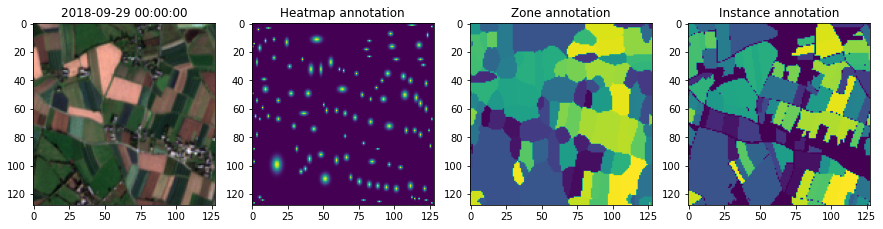

In [45]:
f,axs = plt.subplots(1, 4, figsize=(15, 25))
# axs[0].imshow(get_rgb(time_series))
# axs[0].set_title('Satellite images')
axs[0].imshow(get_rgb(time_series, t_show=7))
axs[0].set_title(f"{metadata[f'{1}_date']}")
axs[1].imshow(heatmap_annotation)
axs[1].set_title('Heatmap annotation')
axs[2].imshow(zone_annotation)
axs[2].set_title('Zone annotation')
axs[3].imshow(instance_annotation)
axs[3].set_title('Instance annotation')

plt.show()

# Deep Learning

## Constants

In [41]:
NUM_CLASSES = 20
VOID_LABEL = 19
TIME_SERIES_LENGTH = 61
TRAIN_BATCH_SIZE = 7   #It was 8 before
VALIDATION_BATCH_SIZE = 1
TEST_BATCH_SIZE = 1

# Train Model constants
TRAIN_LENGTH = 1455
EPOCHS_NUMBER = 25
STEPS_PER_EPOCH = TRAIN_LENGTH // TRAIN_BATCH_SIZE

## UTILS

In [42]:
def one_hot(a, num_classes):
    return np.squeeze(np.eye(num_classes)[a])

def pad_time_series(time_series, size):
    """Pad the input time series with repeated values without violating the temporal feature of the series.
       The output time series will be of a given length and will contain some elements repeated k times and the rest k+1.
       Example: pad_time_series([1, 2, 3, 4], 10) => [1 1 1 2 2 2 3 3 4 4].
    """
    input_size = time_series.shape[0]
    diff = size - input_size
    if diff < 0:
        raise ValueError("Time series length exceeds expected result length")
    elif diff == 0:
        return time_series
    
    duplicate_times = math.ceil(size / input_size)
    repeat_times = [duplicate_times] * (size - input_size * (duplicate_times - 1)) + [duplicate_times - 1] * (input_size * duplicate_times - size)
    repeat_times[:(size - sum(repeat_times))] = [v+1 for v in repeat_times[:(size - sum(repeat_times))]]
    
    pad_result = np.repeat(time_series, repeat_times, axis=0)
    return pad_result

def pad_time_series_by_zeros(time_series, size):
    diff = size - time_series.shape[0]
    if diff < 0:
        raise ValueError("Time series length exceeds expected result length")
    elif diff == 0:
        return time_series
    
    pads = np.zeros(shape=(diff,) + time_series.shape[1:])
    pad_result = np.concatenate([pads, time_series], axis=0)
    return pad_result

## Preprocessing

In [43]:
class ClassWeights(metaclass=Singleton):
    def __init__(self):
        self._class_weights = None
        
    @property
    def class_weights(self):
        if self._class_weights is None:
            self._class_weights = self._calculate_class_weights()
        return self._class_weights
        
    def _calculate_class_weights(self, mode='uniform'):
        """
        Return the list of weights for each class, with the constraint that sum(class_weights) == 1.0
        """
        if mode == 'uniform':
            return [1 / NUM_CLASSES] * NUM_CLASSES
        
        class_weights = [0] * NUM_CLASSES
        for path in patches_metadata['Semantic_segmentation_path']:
            mask = upload_npy_image(path)[0]
            for c in range(NUM_CLASSES):
                class_weights[c] += np.divide(np.count_nonzero(mask == c), mask.shape[0] ** 2)
        class_weights = [w / len(patches_metadata['Semantic_segmentation_path']) for w in class_weights]
        
        class_weights = [1 / w for w in class_weights]
        class_weights = class_weights / sum(class_weights) * 100
        return class_weights

def path_to_timeseries_input(tensor) -> tuple:
    path = tf.get_static_value(tensor).decode("utf-8")
    input_patches = upload_npy_image(path)
    patches = input_patches.swapaxes(1,3).swapaxes(1,2)
    normalized_patches = np.array(list(map(normalize_patch_spectra, patches)))
    pad_patches = pad_time_series_by_zeros(patches, TIME_SERIES_LENGTH)

    segmentation_mask_path = patches_metadata.loc[path]['Semantic_segmentation_path']
    segmentation_mask = upload_npy_image(segmentation_mask_path)[0]
    one_hot_segmentation_mask = one_hot(segmentation_mask, NUM_CLASSES)
    
    class_weights = tf.constant(ClassWeights().class_weights, tf.float32)
    sample_weights = tf.gather(class_weights, indices=tf.cast(segmentation_mask, tf.int32), name='cast_sample_weights')
    
    return pad_patches, one_hot_segmentation_mask, sample_weights

def get_dataset(paths_to_patches):
    files = tf.data.Dataset.list_files(paths_to_patches)
    dataset = files.map(lambda x: tf.py_function(path_to_timeseries_input, [x], [tf.float32, tf.float32, tf.float32]), num_parallel_calls=tf.data.AUTOTUNE)
    return dataset

train_dataset = get_dataset(patches_metadata[patches_metadata['Fold'].isin([1, 2, 3])].index)
validation_dataset = get_dataset(patches_metadata[patches_metadata['Fold'] == 4].index)
test_dataset = get_dataset(patches_metadata[patches_metadata['Fold'] == 5].index)

train_dataset = train_dataset.repeat().batch(TRAIN_BATCH_SIZE)
validation_dataset = validation_dataset.batch(VALIDATION_BATCH_SIZE)
test_dataset = test_dataset.batch(TEST_BATCH_SIZE)

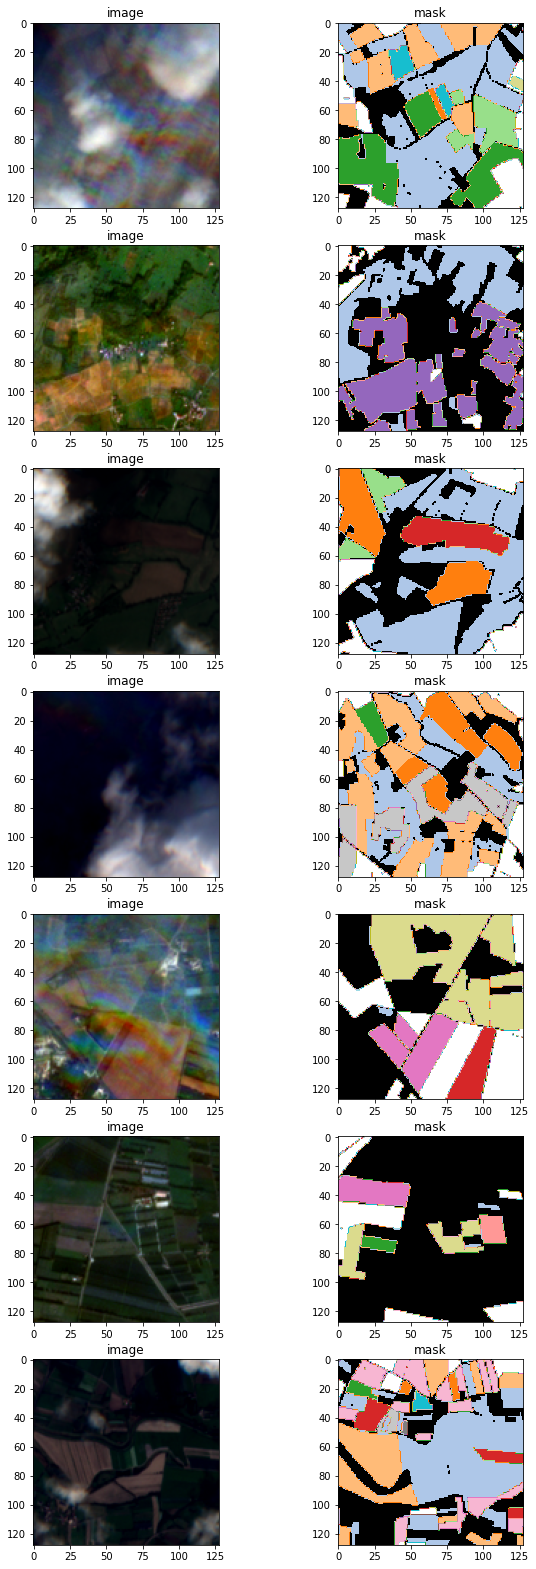

In [44]:
N = 7

f,ax = plt.subplots(N, 2, figsize=(10, 4 * N))
i = 0
for patches, mask_batch, _ in train_dataset.take(N):
    patches = tf.get_static_value(patches)[0].swapaxes(1,2).swapaxes(1,3)
    ax[i, 0].imshow(get_rgb(patches))
    ax[i, 0].set_title('image')
    
    mask = np.argmax(mask_batch[0], axis=2)
    ax[i, 1].imshow(mask, cmap=semantic_cmap, vmin=0, vmax=19)
    ax[i, 1].set_title('mask')
    i += 1

plt.show()

# Unet + CLSTM

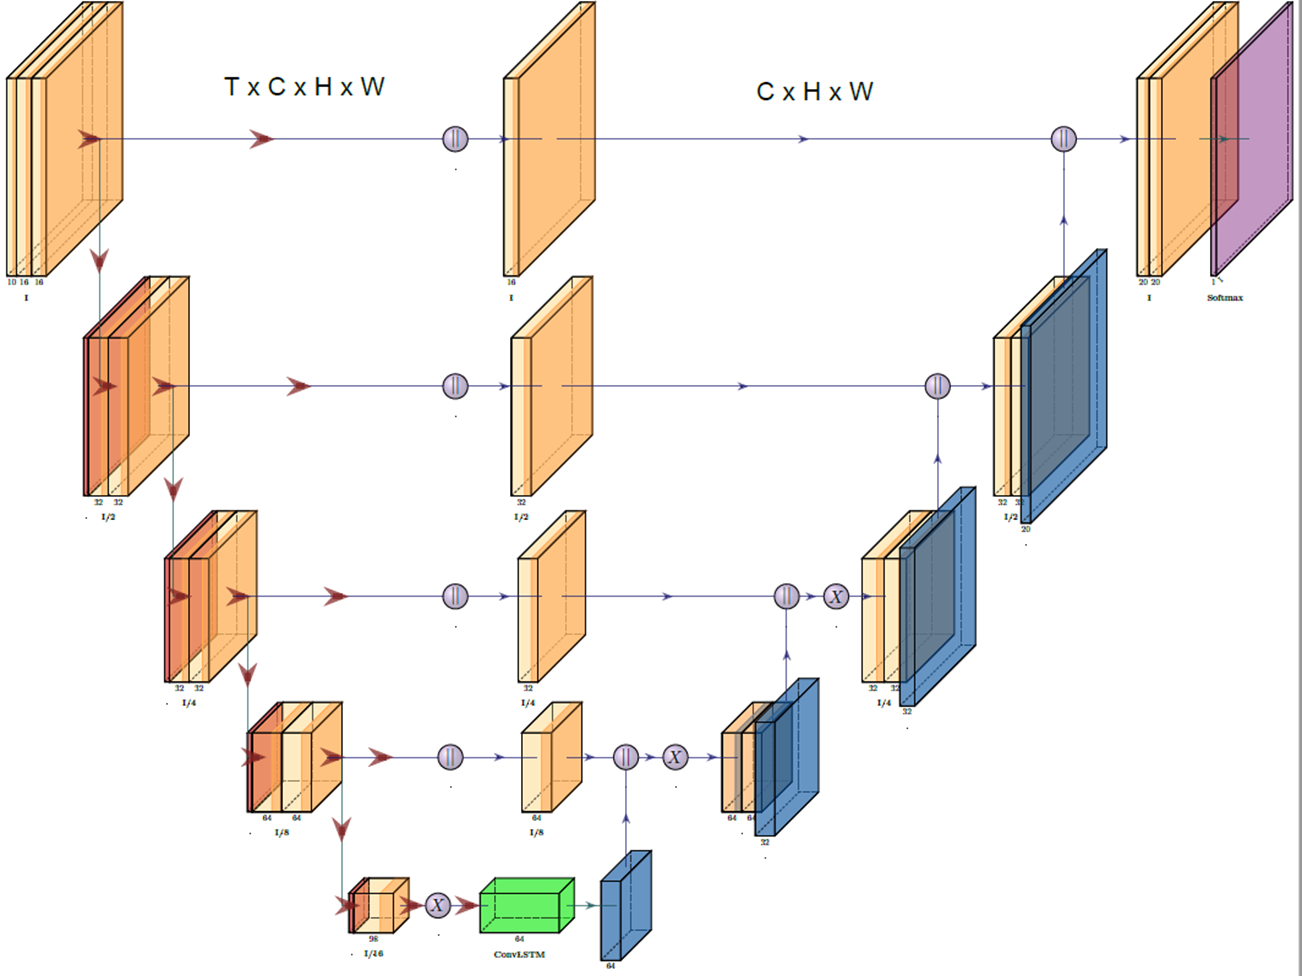

In [ ]:
class UNetConvLSTMModel:
    def __init__(self, num_classes):
        self._model = self._build_model(num_classes)

    @property
    def model(self) -> tf.keras.Model:
        return self._model
    
    def _build_model(self, num_classes, input_shape=(TIME_SERIES_LENGTH, 128, 128, 10)) -> tf.keras.Model:
        inputs = tf.keras.layers.Input(shape=input_shape)
        
        # apply Encoder for each time series image , 
        encoder = self._encoder()
        encoder_outputs = [encoder(inputs[:, i]) for i in range(61)]
        encoder_outputs = list(zip(*encoder_outputs))
        encoder_output = tf.stack(encoder_outputs[-1], axis=1)
        logger.debug(f'Encoder output tensor: {encoder_output}')
        
        # preparing skip connections 
        skip_outputs = [tf.keras.layers.Concatenate()(encoder_output) for encoder_output in encoder_outputs[:-1]] #DenseNet: skip connections via concatenation
        filters_number = [encoder_output[0].shape[-1] for encoder_output in encoder_outputs[:-1]]
        skip_connections = []
        for filters, skip_output in zip(filters_number, skip_outputs):
            skip_connection = self._conv_blocks(filters=filters, size=1, apply_instance_norm=True)(skip_output)
            skip_connections.append(skip_connection)
        logger.debug(f'Skip connections tensors: {skip_connections}')          
        
        # ConvLSTM layer.....to reshape the multivariate time series
        clstm_outputs = tf.keras.layers.ConvLSTM2D(filters=64, kernel_size=3,
                                                   strides=(1, 1), padding='same',
                                                   data_format='channels_last',
                                                   return_state=True)(encoder_output)
        clstm_output = clstm_outputs[-1]
        logger.debug(f'ConvLSTM output tensor: {clstm_output}')
        
        # apply Decoder
        decoder_output = self._decoder(skip_connections, clstm_output)
        logger.debug(f'Decoder output tensor: {decoder_output}')

        # This is the last layers of the model
        output = tf.keras.layers.Conv2D(num_classes, (1, 1), activation='softmax')(decoder_output)
        logger.debug(f'Model output tensor: {output}')

        return tf.keras.Model(inputs=inputs, outputs=output)
    
    def _encoder(self, input_shape=(128, 128, 10)):
        inputs = tf.keras.layers.Input(shape=input_shape)
        outputs = []

        model = tf.keras.Sequential()
        x = model(inputs)

        for filters in [16, 32, 32, 64]:
            x = self._conv_blocks(filters=filters, size=3, apply_instance_norm=True)(x)
            x = self._conv_blocks(filters=filters, size=3, apply_instance_norm=True)(x)
            outputs.append(x)
            x = tf.keras.layers.MaxPool2D(pool_size=(2, 2))(x)

        output = self._conv_blocks(filters=98, size=3, apply_batch_norm=True, apply_dropout=True)(x)
        outputs.append(output)

        # Create the feature extraction model
        encoder = tf.keras.Model(inputs=inputs, outputs=outputs, name="encoder")
        encoder.trainable = True
        return encoder
    
    def _decoder(self, skip_connections, output):     
        x = output
        for filters, skip, apply_dropout in zip([64, 32, 32, 20], skip_connections[::-1], [True, True, False, False]):
            x = self._upsample_block(filters, 3)(x)
            x = tf.keras.layers.Concatenate()([x, skip])
            x = self._conv_blocks(filters, size=3, apply_batch_norm=True, apply_dropout=apply_dropout)(x)
            x = self._conv_blocks(filters, size=3, apply_batch_norm=True)(x)
        return x
    
    def _conv_blocks(self, filters, size, apply_batch_norm=False, apply_instance_norm=False, apply_dropout=False):
        """Downsamples an input. Conv2D => Batchnorm => Dropout => LeakyReLU
            :param:
                filters: number of filters
                size: filter size
                apply_dropout: If True, adds the dropout layer
            :return: Downsample Sequential Model
        """
        initializer = tf.random_normal_initializer(0., 0.02)
        result = tf.keras.Sequential()
        result.add(
          tf.keras.layers.Conv2D(filters, size, strides=1,
                                 padding='same', use_bias=False,
                                 kernel_initializer=initializer,))
        if apply_batch_norm:
            result.add(tf.keras.layers.BatchNormalization())
        if apply_instance_norm:
            result.add(tfa.layers.InstanceNormalization())
        result.add(tf.keras.layers.Activation(tfa.activations.mish))
        if apply_dropout:
            result.add(tf.keras.layers.Dropout(0.55))
        return result
    
    def _upsample_block(self, filters, size, apply_dropout=False):
        """Upsamples an input. Conv2DTranspose => Batchnorm => Dropout => LeakyReLU
            :param:
                filters: number of filters
                size: filter size
                apply_dropout: If True, adds the dropout layer
            :return: Upsample Sequential Model
        """
        initializer = tf.random_normal_initializer(0., 0.02)
        result = tf.keras.Sequential()
        result.add(
          tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                          padding='same',
                                          kernel_initializer=initializer,
                                          use_bias=False))
        result.add(tf.keras.layers.BatchNormalization())
        if apply_dropout:
            result.add(tf.keras.layers.Dropout(0.1))
        result.add(tf.keras.layers.Activation(tfa.activations.mish))
        return result

In [ ]:
class IoU(tf.keras.metrics.Metric):
    def __init__(self, num_classes: int, target_class_ids: list, sparse_y_true: bool, sparse_y_pred: bool,
                 axis: int = -1, name=None, dtype=None):
        super(IoU, self).__init__(name=name, dtype=dtype)
        self.num_classes = num_classes
        self.target_class_ids = target_class_ids
        self.sparse_y_true = sparse_y_true
        self.sparse_y_pred = sparse_y_pred
        self.axis = axis

        # Variable to accumulate the predictions in the confusion matrix.
        self.total_cm = self.add_weight(
            'total_confusion_matrix',
            shape=(num_classes, num_classes),
            initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        """Accumulates the confusion matrix statistics.
        Args:
          y_true: The ground truth values.
          y_pred: The predicted values.
          sample_weight: Optional weighting of each example. Defaults to 1. Can be a
            `Tensor` whose rank is either 0, or the same rank as `y_true`, and must
            be broadcastable to `y_true`.
        Returns:
          Update op.
        """
        
        y_true = tf.reshape(y_true, [-1] + list(y_pred.shape[1:]))
        
        if not self.sparse_y_true:
            y_true = tf.argmax(y_true, axis=self.axis)
        if not self.sparse_y_pred:
            y_pred = tf.argmax(y_pred, axis=self.axis)
            
        y_true = tf.cast(y_true, self._dtype)
        y_pred = tf.cast(y_pred, self._dtype)

        # Flatten the input if its rank > 1.
        if y_pred.shape.ndims > 1:
            y_pred = tf.reshape(y_pred, [-1])

        if y_true.shape.ndims > 1:
            y_true = tf.reshape(y_true, [-1])

        if sample_weight is not None:
            sample_weight = tf.reshape(sample_weight, [-1, 128, 128])
            sample_weight = tf.cast(sample_weight, self._dtype)
            if sample_weight.shape.ndims > 1:
                sample_weight = tf.reshape(sample_weight, [-1])

        # Accumulate the prediction to current confusion matrix.
        current_cm = tf.math.confusion_matrix(y_true, y_pred, self.num_classes, weights=sample_weight, dtype=self._dtype)
        return self.total_cm.assign_add(current_cm)
    
    def reset_state(self):
        tf.keras.backend.set_value(
            self.total_cm, np.zeros((self.num_classes, self.num_classes))
        )
    
    def result(self):
        """Compute the intersection-over-union via the confusion matrix."""
        sum_over_row = tf.cast(
            tf.reduce_sum(self.total_cm, axis=0), dtype=self._dtype)
        sum_over_col = tf.cast(
            tf.reduce_sum(self.total_cm, axis=1), dtype=self._dtype)
        true_positives = tf.cast(
            tf.linalg.tensor_diag_part(self.total_cm), dtype=self._dtype)

        # sum_over_row + sum_over_col = 2 * true_positives + false_positives + false_negatives.
        denominator = sum_over_row + sum_over_col - true_positives

        # Only keep the target classes
        true_positives = tf.gather(true_positives, self.target_class_ids)
        denominator = tf.gather(denominator, self.target_class_ids)

        # If the denominator is 0, we need to ignore the class.
        num_valid_entries = tf.reduce_sum(
            tf.cast(tf.not_equal(denominator, 0), dtype=self._dtype))

        iou = tf.math.divide_no_nan(true_positives, denominator)

        return tf.math.divide_no_nan(
            tf.reduce_sum(iou, name='mean_iou'), num_valid_entries)
    
    def get_config(self):
        config = {
            "num_classes": self.num_classes,
            "target_class_ids": self.target_class_ids,
            "sparse_y_true": self.sparse_y_true,
            "sparse_y_pred": self.sparse_y_pred,
            "axis": self.axis,
        }
        base_config = super().get_config()
        return dict(list(base_config.items()) + list(config.items()))

## Train model

In [ ]:
logger.setLevel(logging.DEBUG)
logger.debug(tf.config.list_physical_devices('GPU'))

def get_compiled_model():
    optimizer = tfa.optimizers.RectifiedAdam(
        learning_rate=0.005,
        total_steps=EPOCHS_NUMBER * STEPS_PER_EPOCH,
        warmup_proportion=0.3,
        min_lr=0.0001,
    )
    optimizer = tfa.optimizers.Lookahead(optimizer)

    loss = tf.keras.losses.CategoricalCrossentropy()
    mIoU = IoU(num_classes=NUM_CLASSES, target_class_ids=list(range(0, NUM_CLASSES)), sparse_y_true=False, sparse_y_pred=False, name='mean-IoU')
    model = UNetConvLSTMModel(NUM_CLASSES).model
    model.compile(optimizer=optimizer,
                  loss=loss,
                  metrics=[mIoU,],
                 )
    return model


model = get_compiled_model()

trainable_params = np.sum([np.prod(v.get_shape().as_list()) for v in model.trainable_variables])
print(f'Trainable params: {trainable_params}')

In [ ]:
checkpoint_filepath = '/kaggle/working/checkpoints/model-checkpoint'
save_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_mean-IoU',
    mode='max',
    save_best_only=True
)

model_history = model.fit(train_dataset,
                          epochs=EPOCHS_NUMBER,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_data=validation_dataset,
                          callbacks=[save_callback])

model.load_weights(checkpoint_filepath)

In [ ]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

mIoU = model_history.history['mean-IoU']
val_mIoU = model_history.history['val_mean-IoU']

plt.figure()
plt.plot(model_history.epoch, loss, 'r', label='Training loss')
plt.plot(model_history.epoch, val_loss, 'c', label='Validation loss')

plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.legend()
plt.show()

In [ ]:
plt.figure()
plt.plot(model_history.epoch, mIoU, 'm', label='Training mean IoU')
plt.plot(model_history.epoch, val_mIoU, 'y', label='Validation mean IoU')

plt.title('Training and Validation Metrics')
plt.xlabel('Epoch')
plt.ylabel('Metric Value')
plt.legend()
plt.show()

In [ ]:
model.save('/kaggle/working/datamodel')

# Results analysis

In [ ]:
results = model.evaluate(test_dataset)
print("test loss, test mIoU:", results)

In [ ]:
TEST_LENGTH = len(patches_metadata[patches_metadata['Fold'] == 5].index)

mIoU = IoU(num_classes=NUM_CLASSES, target_class_ids=list(range(0, NUM_CLASSES)), sparse_y_true=False, sparse_y_pred=False, name='mean-IoU')
for patches, true_mask, _ in test_dataset.take(TEST_LENGTH):
    pred_mask = model.predict(patches)
    mIoU.update_state(true_mask, pred_mask)
    
    mIoU_classes = [IoU(num_classes=NUM_CLASSES, target_class_ids=[c], sparse_y_true=False, sparse_y_pred=False) for c in range(NUM_CLASSES)]
    for c in range(NUM_CLASSES):
        mIoU_classes[c].update_state(true_mask, pred_mask)

print(mIoU.result())

IoU_results_classes = [mIoU_class.result() for mIoU_class in mIoU_classes]
lables = list(range(NUM_CLASSES))
plt.bar(lables, IoU_results_classes,)

In [ ]:
N = 10

f,ax = plt.subplots(N, 3, figsize=(10, 4 * N))
i = 0
for patches, mask_batch, _ in test_dataset.take(N):
    rgb_patches = tf.get_static_value(patches)[0].swapaxes(1,2).swapaxes(1,3)
    ax[i, 0].imshow(get_rgb(rgb_patches))
    ax[i, 0].set_title('image')
    
    mask = np.argmax(mask_batch[0], axis=2)
    ax[i, 1].imshow(mask, cmap=semantic_cmap, vmin=0, vmax=19)
    ax[i, 1].set_title('true mask')

    pred_mask = model.predict(patches)
    pred_mask = np.argmax(pred_mask[0], axis=2)
    ax[i, 2].imshow(pred_mask, cmap=semantic_cmap, vmin=0, vmax=19)
    ax[i, 2].set_title('predicted mask')
    i += 1

plt.show()